In [98]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from keras.src import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report

In [85]:

def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.

    Args:
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.

    Returns:
        A tuple `(data, labels)`.
    """
    with open(fpath, "rb") as f:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels
def load_data_keras():
    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.empty((num_train_samples,), dtype="uint8")
    path = "../Data"
    # batches are within an inner folder
    path = os.path.join(path, "cifar-10-batches-py")
    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        (
            x_train[(i - 1) * 10000 : i * 10000, :, :, :],
            y_train[(i - 1) * 10000 : i * 10000],
        ) = load_batch(fpath)

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if backend.image_data_format() == "channels_last":
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    x_test = x_test.astype(x_train.dtype)
    y_test = y_test.astype(y_train.dtype)

    return (x_train, y_train), (x_test, y_test)        

In [86]:
(x_train, y_train), (x_test, y_test) = load_data_keras()
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


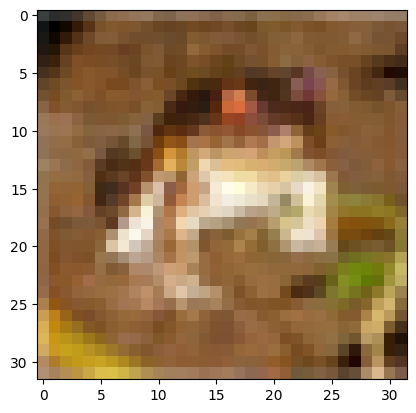

In [87]:
# Check that it's actuall images
plt.imshow(x_train[0])

In [88]:
def rgb2gray(image):
    import cv2
    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

Xdata_training = [ rgb2gray(x_train[i]) for i in range(len(x_train))]
Xdata_testing  = [ rgb2gray(x_test[i]) for i in range(len(x_test))]

In [89]:
# Configuring HOG descriptor
# see http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog

# Configuration of HOG descriptor
normalize = True          #  True ==> yields a little bit better score
                          #  
block_norm = 'L2-Hys'     # or 'L1'
orientations = 9          # 
pixels_per_cell = [8, 8]  #  see section 'Additional remarks' for some explanation
cells_per_block = [2, 2]  # 

def extractFeature(img, vis=False):
    from skimage.feature import hog
    return hog(img, orientations, pixels_per_cell, cells_per_block, block_norm, visualize = vis, transform_sqrt=normalize)

In [90]:
X_training = np.array( [ extractFeature(Xdata_training[i], vis=False) for i in range(len(x_train)) ] )
y_training = np.array( [ y_train[i] for i in range(len(y_train)) ] )

X_testing = np.array( [ extractFeature(Xdata_testing[i], vis=False) for i in range(len(x_test)) ] )
y_testing = np.array( [ y_test[i] for i in range(len(y_test)) ] )

In [91]:
y_training[0]

array([6], dtype=uint8)

In [109]:
n_features = X_training.shape[1]
hog_model = Sequential([
    Input(shape=(n_features,)),
    Flatten(),
    Dense(10, activation='softmax')
])
hog_model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
hog_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 324)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,250 (12.70 KB)

 Trainable params: 3,250 (12.70 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
hog_model.fit(X_training, y_training, epochs=100, batch_size=32, validation_data=(X_testing, y_testing))

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 282us/step - accuracy: 0.3154 - loss: 2.0120 - val_accuracy: 0.4501 - val_loss: 1.6581
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.4632 - loss: 1.6231 - val_accuracy: 0.4707 - val_loss: 1.5651
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - accuracy: 0.4786 - loss: 1.5512 - val_accuracy: 0.4772 - val_loss: 1.5261
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.4852 - loss: 1.5102 - val_accuracy: 0.4833 - val_loss: 1.5064
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - accuracy: 0.4948 - loss: 1.4919 - val_accuracy: 0.4864 - val_loss: 1.4904
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - accuracy: 0.4916 - loss: 1.4791 - val_accuracy: 0.4868 - val_loss: 1.4829
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - accuracy: 0.4967 - loss: 1.4739 - val_accuracy: 0.4893 - val_loss: 1.4785
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - accuracy: 

In [111]:
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

y_pred = hog_model.predict(X_testing)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_testing, y_pred, target_names=classnames, digits=4))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
              precision    recall  f1-score   support

    airplane     0.5911    0.6000    0.5955      1000
  automobile     0.6251    0.5920    0.6081      1000
        bird     0.4577    0.3680    0.4080      1000
         cat     0.4466    0.2510    0.3214      1000
        deer     0.4177    0.5050    0.4572      1000
         dog     0.4139    0.5000    0.4529      1000
        frog     0.5046    0.5980    0.5474      1000
       horse     0.5812    0.5510    0.5657      1000
        ship     0.5885    0.5920    0.5902      1000
       truck     0.5986    0.6680    0.6314      1000

    accuracy                         0.5225     10000
   macro avg     0.5225    0.5225    0.5178     10000
weighted avg     0.5225    0.5225    0.5178     10000

